This notebook loads the results on a test image of M2 (Appendix B in our paper). 

In [1]:
import numpy as np
import torch

import json

import matplotlib.pyplot as plt

import deblending_runjingdev.simulated_datasets_lib as simulated_datasets_lib
import deblending_runjingdev.sdss_dataset_lib as sdss_dataset_lib
import deblending_runjingdev.starnet_lib as starnet_lib
import deblending_runjingdev.sleep_lib as sleep_lib
import deblending_runjingdev.image_statistics_lib as image_statistics_lib
import deblending_runjingdev.daophot_catalog_lib as daophot_catalog_lib

import deblending_runjingdev.plotting_utils as plotting_utils

from deblending_runjingdev.which_device import device

np.random.seed(34534)

# Load the data

In [2]:
x0 = 630
x1 = 210

sdss_image, sdss_background, hubble_locs, hubble_fluxes, sdss_data, wcs = \
    sdss_dataset_lib.load_m2_data(x0 = x0, x1 = x1)

loading sdss image from ../../sdss_stage_dir/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../sdss_stage_dir/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ../hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../sdss_stage_dir/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../sdss_stage_dir/2583/2/136/frame-i-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]



 returning image at x0 = 630, x1 = 210


In [3]:
hubble_locs.shape[0]

1413

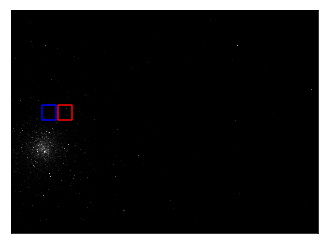

In [4]:
plt.matshow(sdss_data[0]['image'][0], cmap=plt.cm.gray)

# initial region, cataloged by PCAT
# (not exactly 630, 310 to leave some border, so both red and blue boxes show up)
plt.hlines(630, xmin = 315, xmax = 410, color = 'red')
plt.hlines(730, xmin = 315, xmax = 410, color = 'red')
plt.vlines(315, ymin = 630, ymax = 730, color = 'red')
plt.vlines(410, ymin = 630, ymax = 730, color = 'red')


# test region, cataloged by PCAT
plt.hlines(630, xmin = 210, xmax = 305, color = 'blue')
plt.hlines(730, xmin = 210, xmax = 305, color = 'blue')
plt.vlines(210, ymin = 630, ymax = 730, color = 'blue')
plt.vlines(305, ymin = 630, ymax = 730, color = 'blue')

plt.xticks([])
plt.yticks([])

plt.savefig('../../figures/m2_test/m2_regions.png')

In [5]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

# Load StarNet results

### Starnet fit on the original M2 subregion

In [6]:
star_encoder_init = starnet_lib.StarEncoder(slen = 100,
                                            ptile_slen = 8,
                                            step = 2,
                                            edge_padding = 3, 
                                            n_bands = 2,
                                            max_detections = 2)

star_encoder_init.load_state_dict(torch.load('../fits/starnet-encoder-iter2', 
                               map_location=lambda storage, loc: storage))


star_encoder_init.eval(); 
star_encoder_init.to(device);

starnet_init_map_locs, starnet_init_map_fluxes, starnet_init_map_n_stars = \
    star_encoder_init.sample_star_encoder(sdss_image.unsqueeze(0).to(device), 
                                    return_map_n_stars = True, 
                                    return_map_star_params = True)[0:3]

### StarNet refit on this new M2 subregion

In [7]:
star_encoder_refit = starnet_lib.StarEncoder(slen = 100,
                                            ptile_slen = 8,
                                            step = 2,
                                            edge_padding = 3, 
                                            n_bands = 2,
                                            max_detections = 2)

star_encoder_refit.load_state_dict(torch.load('../fits/starnet_m2test-encoder-iter2', 
                               map_location=lambda storage, loc: storage))


star_encoder_refit.eval(); 
star_encoder_refit.to(device);

starnet_refit_map_locs, starnet_refit_map_fluxes, starnet_refit_map_n_stars = \
    star_encoder_refit.sample_star_encoder(sdss_image.unsqueeze(0).to(device), 
                                    return_map_n_stars = True, 
                                    return_map_star_params = True)[0:3]

In [8]:
%timeit star_encoder_refit.sample_star_encoder(sdss_image.unsqueeze(0).to(device), \
                                               return_map_n_stars = True,\
                                               return_map_star_params = True)

32.7 ms ± 516 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Load results from PCAT

In [9]:
chain_results = np.load('../fits/my_chain_m2test.npz')

In [10]:
# we take the last 300 samples of the chain
pcat_n_samples = 300

In [11]:
fudge_factor = sdss_data[0]['gain'][0]

In [12]:
# n_samples x max_stars x n_bands
pcat_sampled_fluxes = chain_results['f'][:, -pcat_n_samples:, :].transpose([1, 2, 0]) * fudge_factor

# get boolean for stars that are on
pcat_is_on_sampled = pcat_sampled_fluxes[:, :, 0] > 0
assert (pcat_is_on_sampled.sum(1) == chain_results['n'][-pcat_n_samples:]).all()

# locations: n_samples x max_stars x 2
pcat_sampled_locs = np.dstack((chain_results['y'][-pcat_n_samples:, :], 
                                    chain_results['x'][-pcat_n_samples:, :]))

# covert everything to torch tensors 
pcat_sampled_locs = torch.Tensor(pcat_sampled_locs).to(device) / (sdss_image.shape[-1] - 1)
pcat_sampled_fluxes = torch.Tensor(pcat_sampled_fluxes).to(device)

In [13]:
pcat_sampled_nstars = chain_results['n'][-pcat_n_samples:]

# Load DAOPHOT catalog

In [14]:
_daophot_locs, _daophot_fluxes = daophot_catalog_lib.load_daophot_results('../daophot_data/m2_2583.phot', 
                                                                            nelec_per_nmgy, 
                                                                            wcs, 
                                                                            x0 = x0, 
                                                                            x1 = x1)

# align the estimated locations ... 
# might have been a slightly different coordinate system?
daophot_locs, daophot_fluxes = daophot_catalog_lib.align_daophot_locs(_daophot_locs,
                                                                      _daophot_fluxes, 
                                                                      hubble_locs,
                                                                      hubble_fluxes[:, 0])

# Get summary statistics

In [15]:
mag_vec = np.concatenate((np.array([15]), 
                          np.arange(19, 22.2, 0.4), 
                          np.array([100])))

In [16]:
def get_summary_statistics(est_locs, est_fluxes): 
    
    # get tpr and ppv as function of magnitude
    tpr_vec = image_statistics_lib.get_tpr_vec(est_locs,
                                               hubble_locs, 
                                               sdss_image.shape[-1], 
                                               est_fluxes, 
                                               hubble_fluxes[:, 0],
                                               nelec_per_nmgy, 
                                               mag_vec = mag_vec)[0]
    
    ppv_vec = image_statistics_lib.get_ppv_vec(est_locs,
                                               hubble_locs, 
                                               sdss_image.shape[-1], 
                                               est_fluxes, 
                                               hubble_fluxes[:, 0],
                                               nelec_per_nmgy, 
                                               mag_vec = mag_vec)[0]
    
    # get overal tpr and ppv    
    tpr, ppv = \
        image_statistics_lib.get_summary_stats(est_locs,
                                               hubble_locs, 
                                               sdss_image.shape[-1], 
                                               est_fluxes, 
                                               hubble_fluxes[:, 0],
                                               nelec_per_nmgy)[0:2]
    # f1 score 
    f1 = 2 * (tpr * ppv) / (tpr + ppv)
    return tpr, ppv, f1, tpr_vec, ppv_vec

### Initial StarNet results

In [17]:
tpr, ppv, f1, starnet_init_tpr_vec, starnet_init_ppv_vec = \
    get_summary_statistics(starnet_init_map_locs.squeeze(0), 
                           starnet_init_map_fluxes[0, :, 0])

print('StarNet-init tpr', tpr)
print('StarNet-init ppv', ppv)
print('StarNet-init f1', f1)

StarNet-init tpr tensor(0.4741, device='cuda:6')
StarNet-init ppv tensor(0.4673, device='cuda:6')
StarNet-init f1 tensor(0.4707, device='cuda:6')


### Refit StarNet results

In [18]:
tpr, ppv, f1, starnet_refit_tpr_vec, starnet_refit_ppv_vec = \
    get_summary_statistics(starnet_refit_map_locs.squeeze(0), 
                           starnet_refit_map_fluxes[0, :, 0])

print('StarNet-refit tpr', tpr)
print('StarNet-refit ppv', ppv)
print('StarNet-refit f1', f1)

StarNet-refit tpr tensor(0.4690, device='cuda:6')
StarNet-refit ppv tensor(0.4951, device='cuda:6')
StarNet-refit f1 tensor(0.4817, device='cuda:6')


### pcat statistics

These are averaged over all the samples

In [19]:
tpr = 0.
ppv = 0.
f1 = 0.

pcat_ppv_vec = torch.zeros(len(mag_vec) - 1)
pcat_tpr_vec = torch.zeros(len(mag_vec) - 1)

for i in range(pcat_n_samples):
    is_on = pcat_is_on_sampled[i]
    
    tpr_i, ppv_i, f1_i, pcat_tpr_vec, pcat_ppv_vec = \
        get_summary_statistics(pcat_sampled_locs[i, is_on, :], 
                               pcat_sampled_fluxes[i, is_on, 0])
    
    pcat_tpr_vec += pcat_tpr_vec / pcat_n_samples
    pcat_ppv_vec += pcat_ppv_vec / pcat_n_samples
    
    tpr += tpr_i / pcat_n_samples
    ppv += ppv_i / pcat_n_samples
    f1 += f1_i / pcat_n_samples

print('PCAT tpr', tpr)
print('PCAT ppv', ppv)
print('PCAT f1', f1)

PCAT tpr tensor(0.4430, device='cuda:6')
PCAT ppv tensor(0.3737, device='cuda:6')
PCAT f1 tensor(0.4054, device='cuda:6')


### DAOPHOT statistics

In [20]:
tpr, ppv, f1, daophot_tpr_vec, daophot_ppv_vec = \
    get_summary_statistics(daophot_locs, 
                           daophot_fluxes.squeeze())

print('DAOPHOT tpr', tpr)
print('DAOPHOT ppv', ppv)
print('DAOPHOT f1', f1)

DAOPHOT tpr tensor(0.1289, device='cuda:6')
DAOPHOT ppv tensor(0.5296, device='cuda:6')
DAOPHOT f1 tensor(0.2074, device='cuda:6')


## Plot statistics as function of magnitude

In [21]:
axis_label_size = 20
ticksize = 12
legendsize = 12
markersize = 10
linewidth = 2
titlesize = 18

In [22]:
def plot_summary_vec(summary_vec, ax, marker, color, label, alpha = 1.0): 
    ax.plot(x_tmp[:-1],
            summary_vec,
            marker, 
            markersize = markersize, 
            linewidth = linewidth, 
            color = color, 
            label = label, 
            alpha = alpha) 

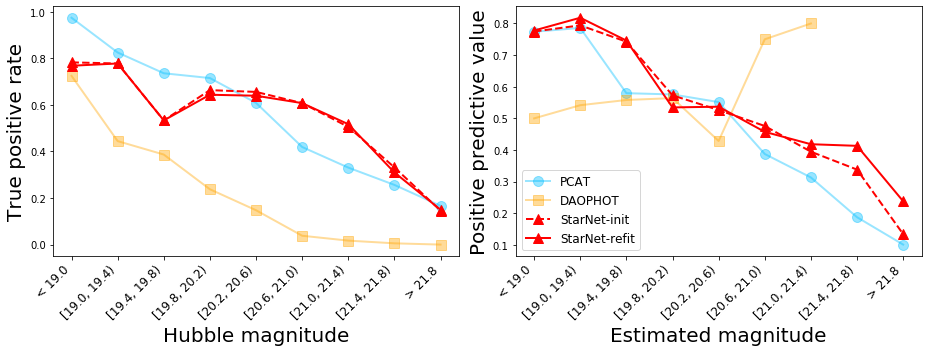

In [23]:
fig, axarr = plt.subplots(1, 2, figsize=(13, 5))

x_tmp = np.arange(len(mag_vec))

############### 
# true positive rates
###############
plot_summary_vec(pcat_tpr_vec, 
                 axarr[0], 
                 marker = '-o', 
                 color = 'deepskyblue', 
                 label = 'PCAT', 
                 alpha = 0.4)

plot_summary_vec(daophot_tpr_vec, 
                 axarr[0], 
                 marker = '-s', 
                 color = 'orange', 
                 label = 'DAOPHOT', 
                 alpha = 0.4)

plot_summary_vec(starnet_init_tpr_vec, 
                 axarr[0], 
                 marker = '--^', 
                 color = 'r', 
                 label = 'StarNet-init')

plot_summary_vec(starnet_refit_tpr_vec, 
                 axarr[0], 
                 marker = '-^', 
                 color = 'r', 
                 label = 'StarNet-refit')

################
# positive predictive values
###############
plot_summary_vec(pcat_ppv_vec, 
                 axarr[1], 
                 marker = '-o', 
                 color = 'deepskyblue', 
                 label = 'PCAT', 
                 alpha = 0.4)

# no detection at lower magnitudes. 
# don't plot them
daophot_ppv_vec[daophot_ppv_vec == 0] = np.inf
plot_summary_vec(daophot_ppv_vec, 
                 axarr[1], 
                 marker = '-s', 
                 color = 'orange', 
                 label = 'DAOPHOT', 
                 alpha = 0.4)

plot_summary_vec(starnet_init_ppv_vec, 
                 axarr[1], 
                 marker = '--^', 
                 color = 'r', 
                 label = 'StarNet-init')

plot_summary_vec(starnet_refit_ppv_vec, 
                 axarr[1], 
                 marker = '-^', 
                 color = 'r', 
                 label = 'StarNet-refit')


###############
# Legend
###############
axarr[1].legend(prop={'size': legendsize})

###############
# axis labels
###############
axarr[0].set_xlabel('Hubble magnitude', fontsize = axis_label_size)
axarr[1].set_xlabel('Estimated magnitude', fontsize = axis_label_size)
axarr[0].set_ylabel('True positive rate', fontsize = axis_label_size)
axarr[1].set_ylabel('Positive predictive value', fontsize = axis_label_size)


labels_raw = np.round(mag_vec, 1)
labels = ['[' + str(labels_raw[i]) + ', ' + str(labels_raw[i+1]) + ')' for i in range(len(labels_raw) - 1)]

labels[0] = '< ' + str(labels_raw[1])
labels[-1] = '> ' + str(labels_raw[-2])

for i in range(2): 
    axarr[i].set_xticks(x_tmp[:-1])
    axarr[i].set_xticklabels(labels, rotation=45, ha = 'right', 
                             fontsize = axis_label_size * 0.6)

fig.tight_layout()
fig.savefig('../../figures/m2_test/summary_statistics_m2.png')
